<a href="https://colab.research.google.com/github/Albertogalred/Data-Science/blob/TFM/NeumoX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INTRODUCTION**

Lung disease is common throughout the world. These include chronic obstructive pulmonary disease, pneumonia, asthma, tuberculosis, fibrosis, etc.

In this work we are going to detect sick lungs through X-ray images applying Deep Learning techniques

**ENVIRONMENT SETUP AND CONFIGURATION**

Keras is a model-level library, providing high-level building blocks for developing deep learning models

In [18]:
!pip install keras

1.-PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks.

2.- Google authentication - Click the link after executing the following commands

In [19]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

3.- Get the identifier of the files in the MyDrive folder

In [20]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: val.zip, id: 1c9VfEbc_WezjvwstMy6D1Zpl5xcmcYH4
title: .ipynb_checkpoints, id: 1-2mIbiWIas_CexviyUBV0SDUNQNRSRT8
title: train.zip, id: 1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp
title: NeumoX, id: 1bSyXkNyzwrxPajbY-WNTiCCs4ycwcYnW
title: test.zip, id: 1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx
title: Colab Notebooks, id: 1Iz8nrdf6kHl5Jimc2xL9zcws8JEA1MUZ


The images have been obtained from:

https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433

In [21]:
file_id = '1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("train.zip")

file_id = '1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("test.zip")

We unzip the information and create the folders for the training, test and validation data

In [22]:
!mkdir NeumoX
!cd NeumoX && unzip -q ../train.zip
!cd NeumoX && unzip -q ../test.zip

mkdir: cannot create directory ‘NeumoX’: File exists
replace train/NORMAL/IM-0115-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
replace test/NORMAL/IM-0001-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [23]:
!pwd

/content


**MODULES IMPORT**

In [24]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dropout,MaxPool2D,Softmax,Input,ELU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add
from keras.metrics import categorical_accuracy
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm  
import cv2   
import scipy
import skimage
from skimage.transform import resize
from matplotlib import pyplot
import matplotlib.pyplot as plt
import h5py
import os, shutil
import glob
import time
import random


**IMAGE PROCESSING AND DISPLAY**

List containing the names of the entries in the directory given by path

In [25]:
Train_normal = os.listdir('../content/NeumoX/train/NORMAL/')
Train_neumonia = os.listdir('../content/NeumoX/train/PNEUMONIA/')

In [26]:
Test_normal = os.listdir('../content/NeumoX/test/NORMAL/')
Test_neumonia = os.listdir('../content/NeumoX/test/PNEUMONIA/')

Sample of 10 healthy lungs

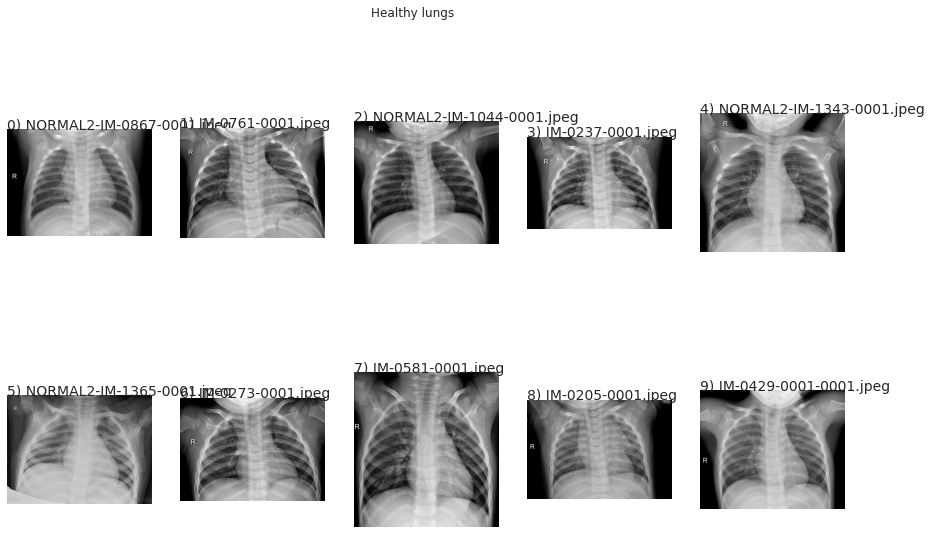

In [27]:
Pnormal = random.sample(Train_normal,10)
f,ax = plt.subplots(2,5,figsize=(15,9))
for i in range(0,10):
    filename=Pnormal[i]
    im = cv2.imread('../content/NeumoX/train/NORMAL/' + Pnormal[i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Healthy lungs')
plt.show()

Sample of 10 diseased lungs

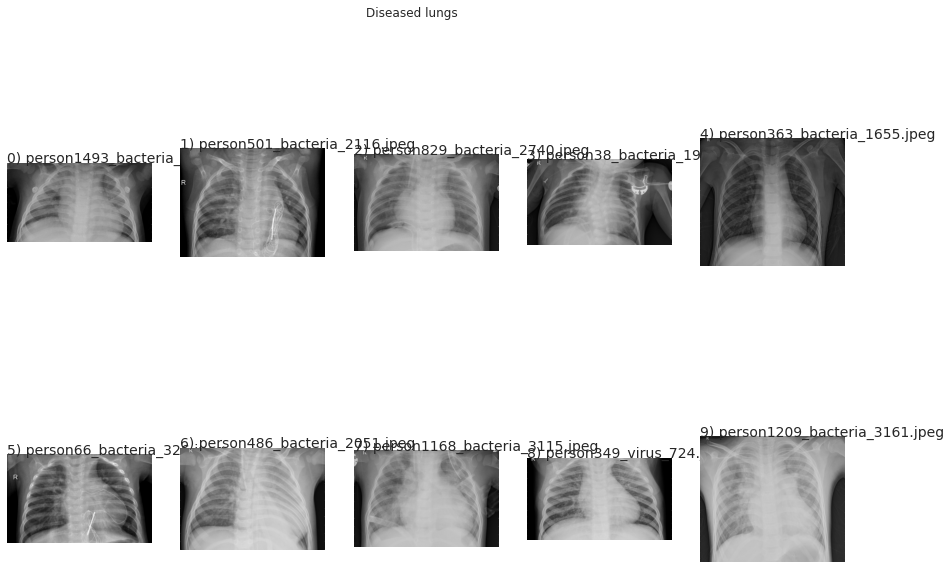

In [28]:
Pneumonia = random.sample(Train_neumonia,10)
f,ax = plt.subplots(2,5,figsize=(15,10))

for i in range(0,10):
    filename=Pneumonia[i]
    im = cv2.imread('../content/NeumoX/train/PNEUMONIA/'+Pneumonia[i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Diseased lungs')
plt.show()

  
TRAIN DATASET
  


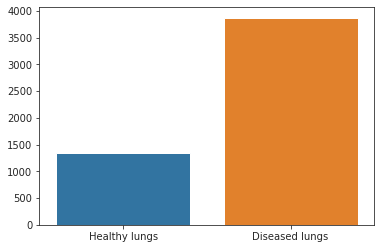

In [29]:
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#sns.set_style('darkgrid')
sns.set_style("ticks")
print('  ')
print('TRAIN DATASET')
print('  ')
sns.barplot(x=['Healthy lungs','Diseased lungs'],y=[len(Train_normal),len(Train_neumonia)]);

Our TRAIN dataset is an imbalanced dataset

  
TEST DATASET
  


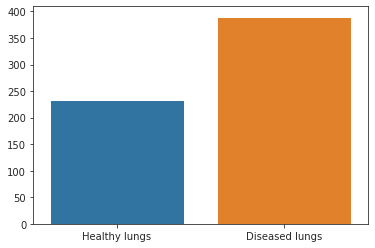

In [30]:
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#sns.set_style('darkgrid')
sns.set_style("ticks")
print('  ')
print('TEST DATASET')
print('  ')
sns.barplot(x=['Healthy lungs','Diseased lungs'],y=[len(Test_normal),len(Test_neumonia)]);

Our TEST dataset is an imbalanced dataset

**IMAGE SIZING**

In [31]:
#np.random.seed(1)
#set_seed(1)

Import Backend utilities

Returns the default image data format convention ('channels_first' or 'channels_last').

Channels first means that in a specific tensor (consider a photo), you would have (Number_Of_Channels, Height , Width).

Channels last means channels are on the last position in a tensor(n-dimensional array).

We have only one channel (greyscale images)

In [32]:

from tensorflow.keras import backend as K

img_width, img_height = 64, 64

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(64, 64, 1)

**LIFE-CYCLE FOR NEURAL NETWORK MODEL IN KERAS**

1.   Define Network
2.   Compile Network
3.   Fit Network
4.   Evaluate Network
5.   Make Predictions

**NEURAL NETWORK MODEL**

Sequential model

In [33]:
## Construction of the Keras Sequential model begins.
model=tf.keras.models.Sequential()

#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
#First convolutional layer with elu-activation
#2D convolution layer (e.g. spatial convolution over images)
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

# For the Conv2D function the specifications and recommendations of the web page have been followed:
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

#Fully connected layers are defined using the Dense class. We can specify the number of neurons or nodes in the layer as the first argument
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
#As the training is not multiclass (a lung is healthy or not), we will use Softmax for the final layer.
model.add(tf.keras.layers.Activation('softmax'))

# Different neural network models have been tested, being the one indicated in this code the one that has given the best results
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

**IMAGE DATA PREPROCESSING**

In [34]:
TRAIN_DIR = "../content/NeumoX/train/"
TEST_DIR =  "../content/NeumoX/test/"

In [35]:
#Generate batches of tensor image data with real-time data augmentation
train_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
test_datagen=image.ImageDataGenerator(rescale=1./255.0)

In [36]:
%matplotlib inline
gen = image.ImageDataGenerator()
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_batches = train_datagen.flow_from_directory("../content/NeumoX/train/",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16, class_mode='binary')
test_batches = test_datagen.flow_from_directory("../content/NeumoX/test/", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**COMPILING THE MODEL**

In [37]:
#We will define the optimizer as the efficient stochastic gradient descent algorithm “adam“
#This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems
#Finally, because it is a classification problem, we will collect and report the classification sparse_categorical_accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

**TRAIN THE MODEL**

In [38]:
#We have defined our model and compiled it ready for efficient computation
#Trains the model for a given number of epochs
history=model.fit(train_batches,validation_data=test_batches,epochs=100, steps_per_epoch=80, validation_steps=20)

Epoch 1/100
80/80 [==============================] - 48s 230ms/step - loss: 2.0706 - sparse_categorical_accuracy: 0.6419 - val_loss: 1.8383 - val_sparse_categorical_accuracy: 0.2688
Epoch 2/100
80/80 [==============================] - 18s 222ms/step - loss: 0.6594 - sparse_categorical_accuracy: 0.7380 - val_loss: 2.2519 - val_sparse_categorical_accuracy: 0.2781
Epoch 3/100
80/80 [==============================] - 18s 221ms/step - loss: 0.5464 - sparse_categorical_accuracy: 0.7909 - val_loss: 0.4621 - val_sparse_categorical_accuracy: 0.8156
Epoch 4/100
80/80 [==============================] - 18s 228ms/step - loss: 0.4682 - sparse_categorical_accuracy: 0.8235 - val_loss: 0.9769 - val_sparse_categorical_accuracy: 0.7344
Epoch 5/100
80/80 [==============================] - 18s 225ms/step - loss: 0.3358 - sparse_categorical_accuracy: 0.8844 - val_loss: 1.1627 - val_sparse_categorical_accuracy: 0.6719
Epoch 6/100
80/80 [==============================] - 18s 231ms/step - loss: 0.3358 - spars

**MODEL EVALUATION**

Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data.

The model evaluates the loss across all of the test patterns, as well as any other metrics specified when the model was compiled, like classification accuracy. A list of evaluation metrics is returned.

In [39]:
score = model.evaluate(test_batches, verbose=0)
print('Test sparse_categorical_accuracy:', score[1])
print('Test loss:', score[0])

Test sparse_categorical_accuracy: 0.9166666865348816
Test loss: 0.29593148827552795


In [40]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


**PREDICT WITH TEST DATA**

In [41]:
tam = len(test_batches)
prediccion_1 = model.predict(test_batches, verbose=True)
prediccion_2 = pd.DataFrame(prediccion_1)
prediccion_2['item']=prediccion_2.reset_index().index
prediccion_2["filename"] = test_batches.filenames
prediccion_2["label"] = (prediccion_2["filename"].str.contains("PNEUMONIA")).apply(int)
prediccion_2['prediccion_2'] = (prediccion_2[1]>0.5).apply(int) #In the test dataset, I indicate that more than a 0.5 probability of being 1 is a 1
print(prediccion_2)
print(prediccion_2.columns)
#batch_size=16 / Found 624 images belonging to 2 classes --> 39

39/39 [==============================] - 5s 125ms/step
                0         1  ...  label prediccion_2
0    8.113984e-01  0.188602  ...      0            0
1    9.990325e-01  0.000968  ...      0            0
2    7.922852e-01  0.207715  ...      0            0
3    9.296282e-01  0.070372  ...      0            0
4    7.871726e-01  0.212827  ...      0            0
..            ...       ...  ...    ...          ...
619  3.369233e-08  1.000000  ...      1            1
620  7.208833e-05  0.999928  ...      1            1
621  1.765280e-02  0.982347  ...      1            1
622  1.365716e-02  0.986343  ...      1            1
623  9.729493e-02  0.902705  ...      1            1

[624 rows x 6 columns]
Index([0, 1, 'item', 'filename', 'label', 'prediccion_2'], dtype='object')


Accuracy = items classified correctly\all items classified

In [42]:
print("Accuracy score ", accuracy_score(prediccion_2["label"], prediccion_2["prediccion_2"]))

Accuracy score  0.9166666666666666


**GRAPHICS AND METRICS**

In [43]:
def plot_metric(history, metric):
    history_loss = history.history #Loss
    vmetricas = history_loss[metric]
    print(vmetricas)
    if 'val_' + metric in history_loss.keys():  
        val_vmetricas = history_loss['val_' + metric]
        
    epochs = range(1, len(vmetricas) + 1)

    if 'val_' + metric in history_loss.keys():  
        plt.plot(epochs, val_vmetricas, label='Test')
    plt.semilogy(epochs, vmetricas, label='Training')

    if 'val_' + metric in history_loss.keys():  
        plt.title('Training and test %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()


[1.557171106338501, 0.5973747968673706, 0.4410833418369293, 0.44240790605545044, 0.3530721068382263, 0.33347874879837036, 0.35864606499671936, 0.3536783754825592, 0.2646489143371582, 0.29323288798332214, 0.2963043451309204, 0.21772901713848114, 0.2619432806968689, 0.27701109647750854, 0.24639615416526794, 0.25131502747535706, 0.19733312726020813, 0.2117367535829544, 0.24150948226451874, 0.19764015078544617, 0.2471778839826584, 0.2137296199798584, 0.19183290004730225, 0.19714747369289398, 0.2012072056531906, 0.1759537160396576, 0.17688682675361633, 0.18344946205615997, 0.2061828076839447, 0.19493889808654785, 0.19410741329193115, 0.18078991770744324, 0.16274365782737732, 0.17174139618873596, 0.18955077230930328, 0.17425033450126648, 0.18915928900241852, 0.18170520663261414, 0.21513135731220245, 0.17736512422561646, 0.16477777063846588, 0.17890608310699463, 0.16643859446048737, 0.17405353486537933, 0.15442362427711487, 0.17136171460151672, 0.1747991442680359, 0.17301900684833527, 0.19712

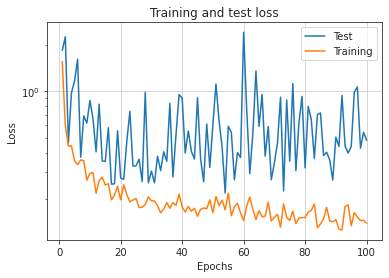

In [44]:
    plot_metric(history,'loss')

[0.6546875238418579, 0.75390625, 0.82421875, 0.832812488079071, 0.8765624761581421, 0.8648437261581421, 0.8531249761581421, 0.8609374761581421, 0.891406238079071, 0.88671875, 0.875, 0.9164062738418579, 0.895312488079071, 0.8929687738418579, 0.901562511920929, 0.901562511920929, 0.92578125, 0.9242187738418579, 0.9078124761581421, 0.918749988079071, 0.9125000238418579, 0.917187511920929, 0.932812511920929, 0.92578125, 0.92578125, 0.944531261920929, 0.932812511920929, 0.938281238079071, 0.92578125, 0.9320312738418579, 0.9320312738418579, 0.9398437738418579, 0.940625011920929, 0.9390624761581421, 0.926562488079071, 0.9437500238418579, 0.934374988079071, 0.94140625, 0.921875, 0.93359375, 0.936718761920929, 0.938281238079071, 0.934374988079071, 0.9390624761581421, 0.9398437738418579, 0.9398437738418579, 0.9437500238418579, 0.9296875, 0.930468738079071, 0.953125, 0.934374988079071, 0.9398437738418579, 0.9296875, 0.9468749761581421, 0.928906261920929, 0.948437511920929, 0.942187488079071, 0.93

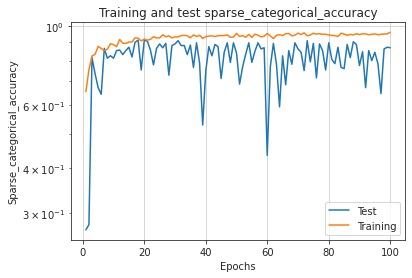

In [45]:
plot_metric(history,'sparse_categorical_accuracy')

The value of sparse_categorical_accuracy indicates the part of the correct conjectures: we can see that as we run epochs it increases its value until it reaches the maximum. On the other hand, the value of val_sparse_categorical_accuracy, which is calculated with the test data that has not been used in the training, is lower reaching a threshold that cannot be exceeded. This is exactly what tells us that the **Overfitting** effect is taking place from a number of epochs.

**100 first predictions**

In [46]:
prediccion_2[:30]

,0,1,item,filename,label,prediccion_2
0,0.811398,0.188602,0,NORMAL/IM-0001-0001.jpeg,0,0
1,0.999032,0.000968,1,NORMAL/IM-0003-0001.jpeg,0,0
2,0.792285,0.207715,2,NORMAL/IM-0005-0001.jpeg,0,0
3,0.929628,0.070372,3,NORMAL/IM-0006-0001.jpeg,0,0
4,0.787173,0.212827,4,NORMAL/IM-0007-0001.jpeg,0,0
5,0.994320,0.005680,5,NORMAL/IM-0009-0001.jpeg,0,0
6,0.726700,0.273300,6,NORMAL/IM-0010-0001.jpeg,0,0
7,0.776033,0.223967,7,NORMAL/IM-0011-0001-0001.jpeg,0,0
8,0.745894,0.254106,8,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,0.953381,0.046619,9,NORMAL/IM-0011-0001.jpeg,0,0


Example wrong prediction - Healthy lung that the model has predicted to be a diseased lung

Indicates a wrong item from the table above
16


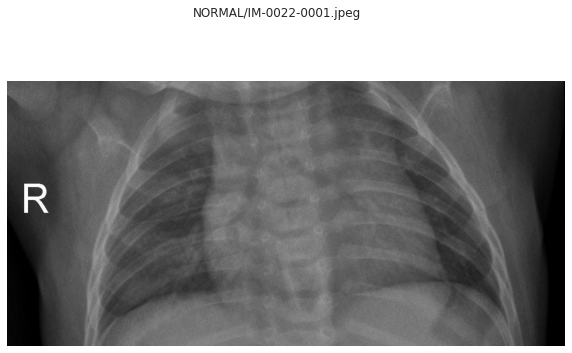

In [47]:
print("Indicates a wrong item from the table above")
Erronea = input()
Erronea = int(Erronea)
prediccion_2["filename"][Erronea]
f,ax = plt.subplots(1,1,figsize=(10,6))
im = cv2.imread('../content/NeumoX/test/'+prediccion_2["filename"][Erronea])
ax.imshow(im)
ax.axis('off')
f.suptitle(prediccion_2["filename"][Erronea])
plt.show()

**CONFUSION MATRIX**

It is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class

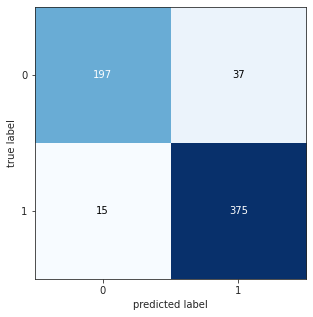

In [48]:
CMatrix = confusion_matrix(prediccion_2["label"], prediccion_2["prediccion_2"])
fig, ax = plot_confusion_matrix(conf_mat=CMatrix ,  figsize=(5, 5))
plt.show()

**PRECISION AND RECALL**

1.   The precise definition of **recall** is the number of true positives divided by the number of true positives plus the number of false negatives
2.   **Precision** is defined as the number of true positives divided by the number of true positives plus the number of false positives
3.   The **F1 score** is the harmonic mean of precision and recall taking both metrics into account. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).




In [49]:
# Calculate Precision and Recall
tn, fp, fn, vp = CMatrix.ravel()
print(tn, fp, fn, vp,CMatrix)
precision = vp/(vp+fp)
recall = vp/(vp+fn)
F1_score = 2*(precision*recall)/(precision+recall)

197 37 15 375 [[197  37]
 [ 15 375]]


In [50]:
print("Precision of the model is {:.2f}".format(precision))
print("Recall of the model is {:.2f}".format(recall))
print("F1_score of the model is {:.2f}".format(F1_score))

Precision of the model is 0.91
Recall of the model is 0.96
F1_score of the model is 0.94


**WRONG PREDICTIONS**

In [51]:
wrong=np.where(prediccion_2['prediccion_2']!=prediccion_2['label'])[0]

In [52]:
print(" Number of wrong prediction:", len(wrong))

 Number of wrong prediction: 52


In [53]:
wrong

array([ 16,  72,  83,  85,  89, 103, 104, 113, 117, 118, 119, 120, 121,
       122, 123, 124, 126, 129, 130, 131, 132, 133, 134, 135, 136, 140,
       142, 143, 144, 145, 146, 160, 171, 182, 193, 220, 226, 281, 282,
       287, 288, 317, 382, 388, 390, 391, 405, 408, 417, 476, 599, 612])

**CLASSIFICATION REPORT**

Build a text report showing the main classification metrics

In [54]:
Etiq = ['Normal lung', 'Diseased lung']
print(classification_report(prediccion_2["label"], prediccion_2["prediccion_2"], target_names=Etiq))
#Support: number of observations for each class.
#Macro average: the arithmetic average of a metric between the two classes.
#  Example: Macro average(precision) = (p0 + p1)/2 = (0.93 + 0.89)/2 = 0.91 = 91%
#Weighted average: the weighted average is calculated by dividing sum(metric of interest x weight) by sum(weights)
#  Weighted average (precision)= (p0 x s0 + p1 x s1)/(s0 + s1) = (0.93 x 234) + (0.89 x 390)/(234 + 390) = 0.90 = 90%

               precision    recall  f1-score   support

  Normal lung       0.93      0.84      0.88       234
Diseased lung       0.91      0.96      0.94       390

     accuracy                           0.92       624
    macro avg       0.92      0.90      0.91       624
 weighted avg       0.92      0.92      0.92       624



**AUC - ROC Curve**

It is one of the most important evaluation metrics for checking any classification model’s performance

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

The ROC curve is plotted with TPR (True Positive Rate or Recall) against the FPR (False Positive Rate).

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has AUC near to the 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

When AUC is approximately 0.5, this is the worst situation, the model has no discrimination capacity to distinguish between positive class and negative class.

When AUC is approximately 0, the model is actually reciprocating the classes. It means the model is predicting a negative class as a positive class and vice versa.






In [55]:
# calculate AUC
auc = roc_auc_score(prediccion_2["label"], prediccion_2["prediccion_2"])

In [56]:
print('AUC: %.3f' % auc)

AUC: 0.902


In [57]:
print('AUC is {:.4f}' .format(auc) ,end=""),
print(', it means there is a {:.2f}' .format(auc*100) ,end=""), 
print('% chance that the model will be able to distinguish between positive class and negative class.')

AUC is 0.9017, it means there is a 90.17% chance that the model will be able to distinguish between positive class and negative class.


In [58]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(prediccion_2["label"], prediccion_2["prediccion_2"])

Graphic examples

AUC = 1

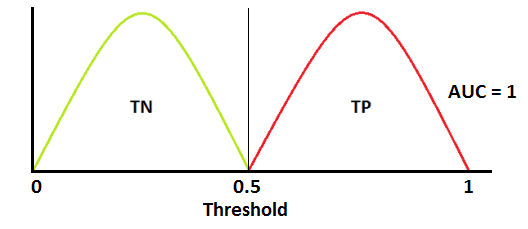
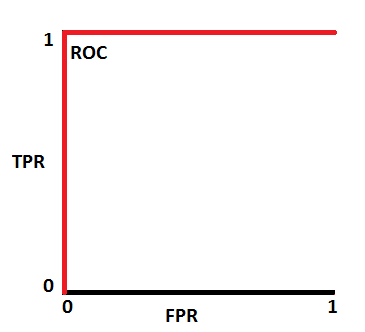

AUC = 0.7

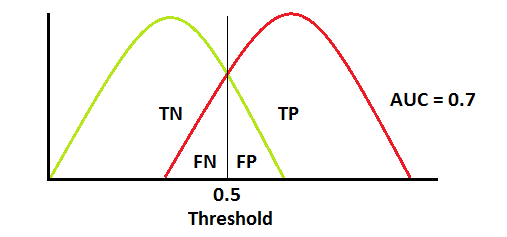
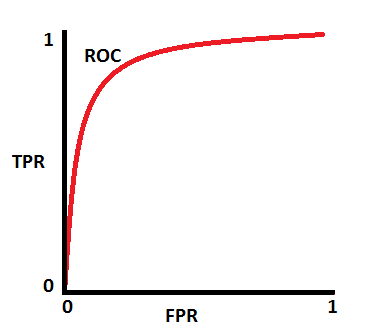

AUC = 0.5

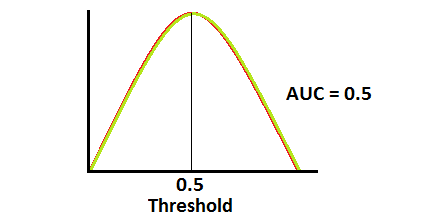
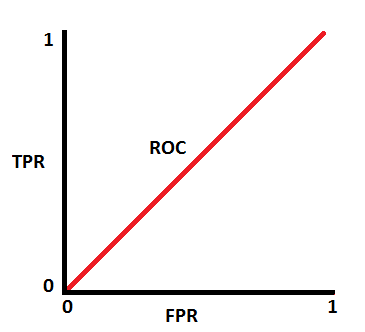



AUC = 0

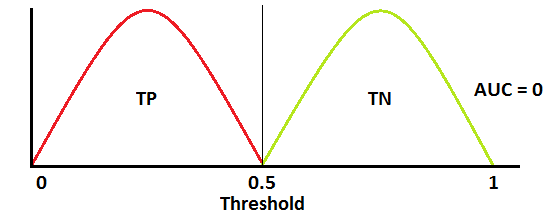
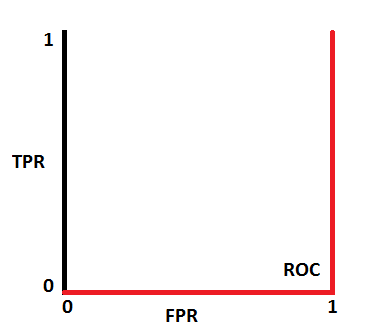

In our model the graph looks like this

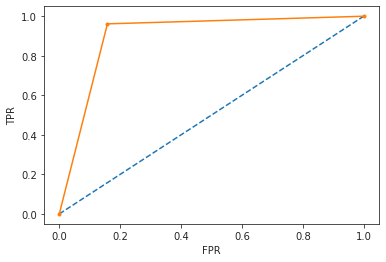

In [59]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr,tpr, marker='.')
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
# show the plot
pyplot.show()

**PRECISION-RECALL (PR) CURVE**

The precision and recall metrics are related so that if you train your classifier to increase **precision**, the **recall** will decrease and vice versa.

Suppose we want to make our classifier very sensitive to images of diseased lungs, that is, we want to increase the recall, probably to a value close to 1 (100%). We could do this easily if we make our model a simple function that always returns 1. The downside to this is that our precision would be very poor, practically random, probably close to 0.5 if our dataset is balanced.

Now suppose we want a very precise classifier, with a precision close to 1. Obviously, if our classifier is very strict when it comes to considering a diseased lung image, we will miss many by the way and this will reduce the recall. Our classifier will be very accurate, but less sensitive.

And how do we tell the classifier if we want it to be more precise, or more sensitive? Generally, the model will make the decision of whether the classification is positive or negative if the value returned by the model exceeds a decision threshold. If we increase this value, we will be increasing the precision, if we decrease it, we will increase the sensitivity (recall)

No skill: 0.625
The precision-recall curve plot is then created showing the precision/recall for each threshold for the model (orange) compared to a no skill model (blue).


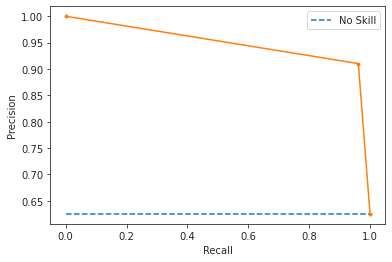

Average Precision Score=0.899


In [60]:
precision, recall, _ = precision_recall_curve(prediccion_2["label"], prediccion_2["prediccion_2"])
no_skill = len(prediccion_2["label"][prediccion_2["label"]==1]) / len(prediccion_2["label"])
ap = average_precision_score(prediccion_2["label"], prediccion_2["prediccion_2"])
print("No skill:",  no_skill)
print("The precision-recall curve plot is then created showing the precision/recall for each threshold for the model (orange) compared to a no skill model (blue).")
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print('Average Precision Score=%.3f' % (ap))

Generally, the use of ROC curves and precision-recall curves are as follows:

1.   ROC curves should be used when there are roughly equal numbers of observations for each class.
2.   Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

**CONCLUSIONS**

The results described in this work recommend that the deep learning models can be utilized to improve the diagnosis compared to the traditional methods. As a result, the quality of the affected patient's treatment can be improved. 

Our model can efficiently detect the inflammatory area in chest X-ray images. 